In [ ]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from glob import glob
from tqdm import tqdm
import pydicom as dicom

In [ ]:
testDir = r"C:\Users\Ann\Downloads\stage_2_test_images"
trainDir = r"C:\Users\Ann\Downloads\stage_2_train_images"
#both methods work.

#get len of test and train folders, should be 3000, ~26,000
def filelen(dir):
    count = 0
    for path in os.listdir(dir):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir, path)):
            count += 1
    return count
#test
print(filelen(testDir),filelen(trainDir))

#puts all file names in an array 
def dir2Array(dir):
    returnarr = [None] * filelen(dir)
    count = 0
    for entry in os.scandir(dir):
        if entry.is_file():
            returnarr[count] = dicom.dcmread(f"{entry.path}").pixel_array
        count = count + 1
    return returnarr
    #plot images using this repeatedly for testing

def plotImgs(arr,row,col):
    fig,axes = plt.subplots(row,col)
    for i, ax in enumerate(axes.flat):
        ax.imshow(arr[i], cmap = plt.cm.gray) 
        ax.axis('off') 
    plt.tight_layout()
    plt.show()



3000 26684


In [ ]:
# run separately for time
testds = dir2Array(testDir)

In [ ]:
# trainds = dir2Array(trainDir)

RuntimeError: Unable to decode as exceptions were raised by all available plugins:
  pillow: 

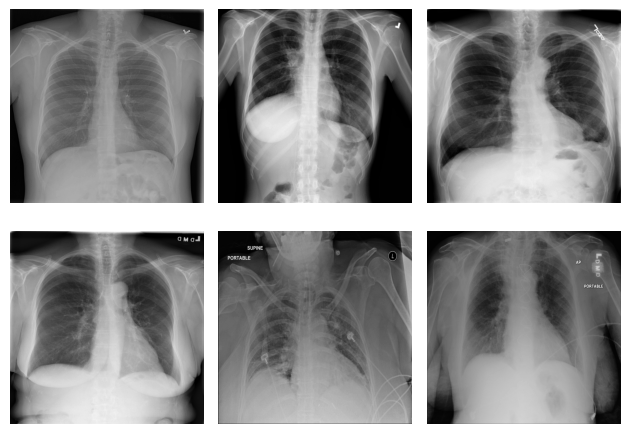

In [68]:
plotImgs(testds,2,3)

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage.morphology import binary_closing, disk
from skimage.morphology import remove_small_objects
from skimage.measure import label,regionprops

image = testds[0].astype(float)
def ridTrach(cleared):
    label_img = label(cleared)
    numregion = len(regionprops(label_img))
    idxsize = 5000
    while numregion != 2:
        if numregion > 2:
            idxsize = idxsize + 1000
            label_img = remove_small_objects(label_img, min_size = idxsize)
        elif numregion == 2:
            idxsize = idxsize
            label_img = remove_small_objects(label_img, min_size = idxsize)
        else:
            print("you messed up")
    return label_img

#segmentation for top part of lung
def segLungTop(img):
    thresh_val = 115
    binary_image = img < thresh_val
    cleared = clear_border(binary_image)
    #remove trachea and small holes
    filtered = ridTrach(cleared)
    # #smooth image
    smoothed = binary_closing(filtered, footprint=disk(5))
    array2plot  = [binary_image,cleared,filtered,smoothed]
    return smoothed, array2plot

finimg,imgarray = segLungTop(image)
plotImgs(imgarray,2,2)

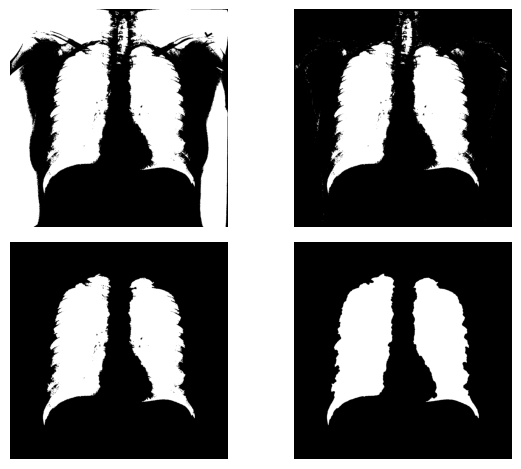

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage.morphology import binary_closing, disk
from skimage.morphology import remove_small_objects
from skimage.measure import label,regionprops

#segmentation for top part of lung
def segLungTop(img):
    thresh_val = 115
    binary_image = img < thresh_val
    cleared = clear_border(binary_image)
    #remove trachea and small holes
    filtered = remove_small_objects(cleared, min_size = 6000)
    # #smooth image
    smoothed = binary_closing(filtered, footprint=disk(5))
    array2plot  = [binary_image,cleared,filtered,smoothed]
    return smoothed, array2plot

finimg,imgarray = segLungTop(image)
plotImgs(imgarray,2,2)

2


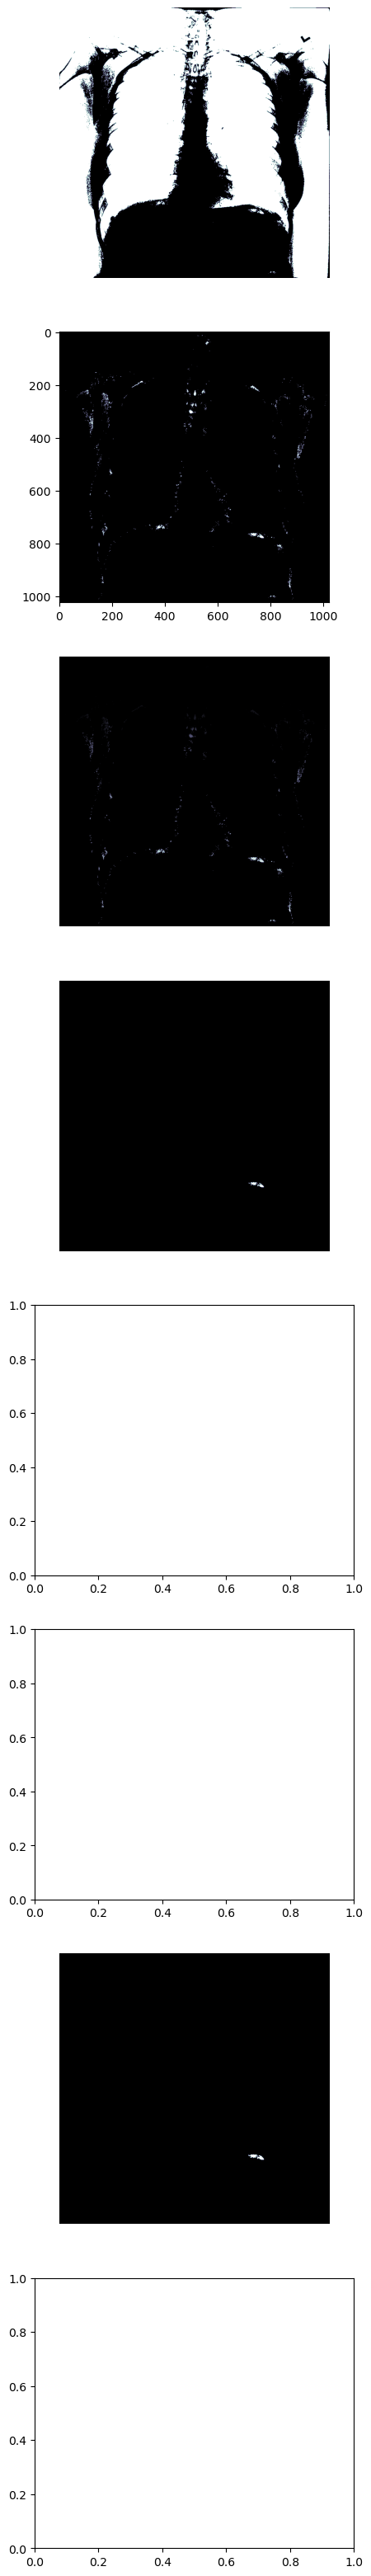

In [131]:
from scipy import ndimage as ndi
from skimage.filters import roberts, sobel
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops

def segLung(img, plot = False):
    binary = img < 125
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
        cleared = clear_border(binary)
    if plot == True:
        # plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone)
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone)
        edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    return binary
img = testds[0].astype(float)

test_seg = segLung(img,True)

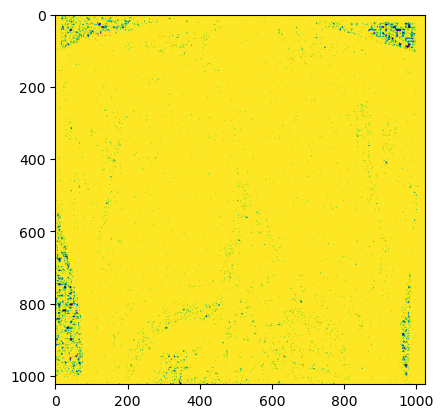

In [ ]:
import skimage as ski
from cv2 import cvtColor
img = testds[0]
from sklearn.cluster import spectral_clustering
# img += 1 + 0.2 * np.random.randn(*img.shape)
from sklearn.feature_extraction import image
mask = img.astype(bool)


graph = image.img_to_graph(img, mask=mask)

graph.data = np.exp(-graph.data / graph.data.std())
res, edge = cv2.threshold(img, 115,255,cv2.THRESH_BINARY)

edge = ski.filters.sobel((edge))

markers = np.zeros_like(img)
markers[img < 135] = 1
markers[img > 200] = 2
# cv2.imshow('Binary Threshold', edge)
plt.imshow(markers)
from skimage.segmentation import watershed
# segmentation = ski.segmentation.watershed(edge, markers)
# plt.imshow(segmentation)

mask = edge.astype(bool)

plt.imshow(mask)


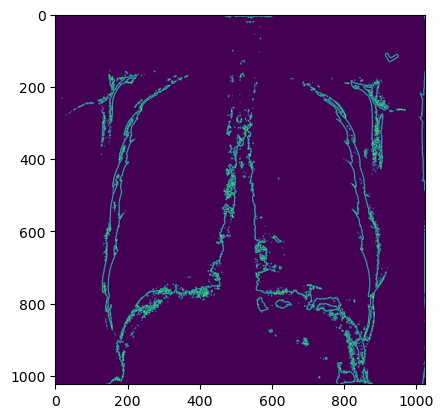

In [ ]:
import skimage as ski
markers = np.zeros_like(edge)
edge = ski.filters.sobel(img)
markers[img < 30] = 1
markers[img > 150] = 2
plt.imshow(edge)

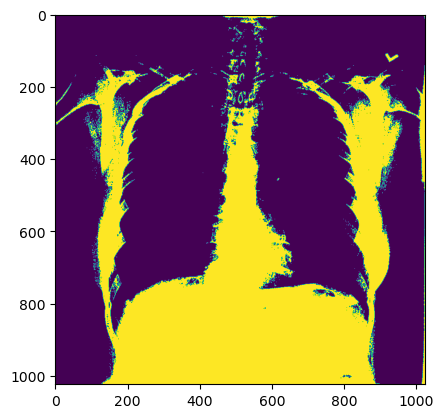

: 

In [ ]:
plt.imshow(edge) 